<a href="https://colab.research.google.com/github/sudarshan-360/Machine-Learning/blob/main/skin_tone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python mediapipe numpy scikit-learn


📸 Upload your selfie image:


Saving WhatsApp Image 2025-08-05 at 19.39.21.jpeg to WhatsApp Image 2025-08-05 at 19.39.21 (3).jpeg
🎨 Dominant Skin Tone (HSV): H=14.28, S=101.21, V=209.35


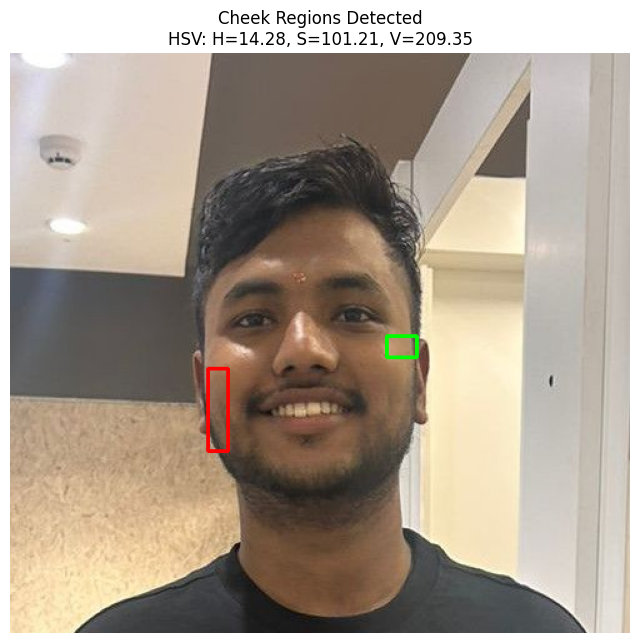

In [5]:
from google.colab import files
import cv2
import numpy as np
import mediapipe as mp
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Upload image
print("📸 Upload your selfie image:")
uploaded_img = files.upload()
img_path = next(iter(uploaded_img))

# Initialize MediaPipe
mp_face_mesh = mp.solutions.face_mesh

# Facial landmarks for cheeks
left_cheek_ids = [454, 356, 447, 345, 346]
right_cheek_ids = [234, 93, 132, 58, 172]

def extract_region(image, face_landmarks, landmark_ids):
    h, w, _ = image.shape
    points = []

    for id in landmark_ids:
        lm = face_landmarks.landmark[id]
        x, y = int(lm.x * w), int(lm.y * h)
        points.append((x, y))

    x_coords = [pt[0] for pt in points]
    y_coords = [pt[1] for pt in points]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    return image[y_min:y_max, x_min:x_max], (x_min, y_min, x_max, y_max)

def dominant_skin_hsv(roi, k=3):
    hsv = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])

    pixels = hsv.reshape((-1, 3))
    pixels = pixels[np.any(pixels != [0, 0, 0], axis=1)]

    if len(pixels) == 0:
        return None

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(pixels)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Select cluster with highest brightness (value)
    max_v_index = np.argmax(cluster_centers[:, 2])
    dominant_hsv = cluster_centers[max_v_index]
    return dominant_hsv

def extract_skin_tone(image_path):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    vis_image = image_rgb.copy()

    with mp_face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
        result = face_mesh.process(image_rgb)

        if not result.multi_face_landmarks:
            print("❌ No face detected.")
            return

        landmarks = result.multi_face_landmarks[0]

        # Extract both cheeks and bounding boxes
        left_cheek, left_box = extract_region(image_rgb, landmarks, left_cheek_ids)
        right_cheek, right_box = extract_region(image_rgb, landmarks, right_cheek_ids)

        # Resize right cheek to match left cheek size
        left_h = left_cheek.shape[0]
        right_cheek_resized = cv2.resize(right_cheek, (left_cheek.shape[1], left_h))
        cheeks_combined = np.concatenate([left_cheek, right_cheek_resized], axis=1)

        # Get dominant HSV
        hsv = dominant_skin_hsv(cheeks_combined)

        if hsv is not None:
            h, s, v = hsv
            print(f"🎨 Dominant Skin Tone (HSV): H={h:.2f}, S={s:.2f}, V={v:.2f}")
        else:
            print("❌ No valid skin pixels found.")
            return

        # Draw visual bounding boxes on image
        lx1, ly1, lx2, ly2 = left_box
        rx1, ry1, rx2, ry2 = right_box

        cv2.rectangle(vis_image, (lx1, ly1), (lx2, ly2), (0, 255, 0), 2)
        cv2.rectangle(vis_image, (rx1, ry1), (rx2, ry2), (255, 0, 0), 2)

        # Show image with overlay
        plt.figure(figsize=(8, 8))
        plt.imshow(vis_image)
        plt.title(f'Cheek Regions Detected\nHSV: H={h:.2f}, S={s:.2f}, V={v:.2f}')
        plt.axis('off')
        plt.show()

# Run it
extract_skin_tone(img_path)
